# Linear Programming Solver

This notebook implements a two-phase simplex-like algorithm for solving linear programming problems.

## Problem Formulation
Maximize: $c^T z$  
Subject to: $Az \leq b$

## Algorithm Overview
1. **Find Initial Feasible Point**: Use origin if feasible, otherwise solve modified LP
2. **Phase 1**: Move from feasible point to vertex using null space directions
3. **Phase 2**: Move from vertex to optimal vertex using basic directions
4. **Degeneracy Handling**: Apply epsilon perturbations when needed

## Import Required Libraries

In [1]:
import csv
from sympy import Matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
np.random.seed(45)

## Utility Functions for Formatted Output

In [16]:
def print_header(text, width=70):
    """Print a formatted header"""
    print("\n" + "=" * width)
    print(f"  {text}")
    print("=" * width)

def print_subheader(text, width=70):
    """Print a formatted subheader"""
    print("\n" + "-" * width)
    print(f"  {text}")
    print("-" * width)

def print_info(label, value, indent=2):
    """Print labeled information"""
    print(" " * indent + f"{label}: {value}")

## Modified LP Construction

When the origin is not feasible, we construct a modified LP by adding an auxiliary variable.

In [17]:
def get_modified_LP(_A, _b, _c):
    min_b = min(_b)
    initial_point = np.zeros((_A.shape[1] + 1, 1))
    initial_point[-1] = min_b
    modified_A, modified_b, modified_c = _A, _b, _c

    if initial_point.shape != _c.shape:
        rows, cols = _A.shape
        modified_A = np.append(np.append(_A, np.zeros((1, cols)), axis=0), np.ones((rows + 1, 1)), axis=1)
        modified_A[-1][-1] = -1
        modified_b = np.append(_b, [abs(min(_b))], axis=0)
        modified_c = np.zeros((cols + 1, 1))
        modified_c[-1] = 1

    return modified_A, modified_b, np.hstack(modified_c), np.hstack(initial_point)

## Phase 1: Feasible Point to Vertex

This function moves from any feasible point to a vertex by moving along null space directions of tight constraints until the rank equals the dimension.

In [18]:
def feasible_to_vertex_movement(_matrix_A, _vector_b, _vector_z, _vector_c, _dimension_n):
    """
    Phase 1: Move from a feasible point to a vertex using null space directions.
    
    Iteratively moves along null space directions of tight constraints, increasing the rank
    of the tight constraint matrix until it reaches full rank (vertex with exactly n tight constraints).
    
    Returns:
        - (None,) if degeneracy detected or max iterations reached
        - (z_vertex, costs, points) if vertex successfully found
    """
    track_cost = []
    track_z = []
    track_cost.append(np.dot(_vector_c, _vector_z))
    track_z.append(_vector_z)

    z_old = _vector_z
    iteration = 0
    print_interval = 1

    # Find tight rows
    epi = 1e-8
    product = np.dot(_matrix_A, _vector_z)
    mask = np.abs(product - _vector_b) < epi
    tight_rows = _matrix_A[mask]
    untight_rows = _matrix_A[~mask]

    if len(tight_rows) == 0:
        rank = 0
    else:
        rank = np.linalg.matrix_rank(tight_rows)

    if rank == _dimension_n:
        return z_old, track_cost, track_z
    else:
        print_subheader("Phase 1: Moving from Feasible Point to Vertex")
        print(f"  Initial rank: {rank} (target: {_dimension_n})")

    max_iterations = 100000  # Prevent infinite loop
    while rank != _dimension_n and iteration < max_iterations:
        iteration += 1

        if iteration % print_interval == 0:
            print(f"  Iteration {iteration:5d} | Rank: {rank}/{_dimension_n}")
            if iteration > 300:
                print_interval = 1000
            elif iteration > 10000:
                print_interval = 10000

        if len(tight_rows) == 0:
            u = np.random.rand(untight_rows.shape[-1])
        else:
            # Use SymPy for null space computation
            tight_matrix = Matrix(tight_rows)
            null_space_basis = tight_matrix.nullspace()
            if null_space_basis:
                u = np.array(null_space_basis[0]).astype(np.float64).flatten()
            else:
                u = np.random.rand(tight_rows.shape[-1])

        # Try both directions, but limit attempts to prevent infinite loop
        direction_attempts = 0
        max_direction_attempts = 2
        while direction_attempts < max_direction_attempts:
            alphas = [(_b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) for _b_i, a2_i in zip(_vector_b[~mask], untight_rows)]
            alphas = [alpha for alpha in alphas if alpha > 0]

            positive_alphas = []
            epi = 1e-10
            for i in alphas:
                if not(i == np.inf or abs(i) < epi):
                    positive_alphas.append(i)

            if len(positive_alphas) == 0:
                direction_attempts += 1
                u = -1*u
            else:
                break
        
        # If no valid direction found after trying both, this is degeneracy
        if len(positive_alphas) == 0:
            return (None,)

        alpha = min(positive_alphas)
        z_new = z_old + alpha * u
        
        # Find tight rows
        product = np.dot(_matrix_A, z_new)
        mask = np.abs(product - _vector_b) < epi
        tight_rows = _matrix_A[mask]
        untight_rows = _matrix_A[~mask]
        
        z_old = z_new

        if len(tight_rows) == 0:
            rank = 0
        else:
            rank = np.linalg.matrix_rank(tight_rows)

        track_cost.append(np.dot(_vector_c, z_new))
        track_z.append(z_new)

    # Check if max iterations reached
    if iteration >= max_iterations:
        print(f"  [WARNING] Maximum iterations ({max_iterations}) reached in Phase 1")
        return (None,)

    if not(tight_rows.shape[0] > tight_rows.shape[1]):
        return (z_new, track_cost, track_z)
    else:
        return (None,)

## Phase 2: Vertex to Optimal Vertex

This function moves from a vertex to the optimal vertex by iteratively selecting cost-improving basic directions.

In [19]:
def vertex_to_vertex_movement(_matrix_A, _vector_b, _vector_z, _vector_c, _columns):
    """
    Phase 2: Move from a vertex to the optimal vertex using basic directions.
    
    Iteratively moves along cost-improving directions (computed from tight constraint inverse)
    until no improving directions exist (optimal) or the problem is unbounded.
    
    Returns:
        - (None,) if degeneracy detected
        - (None, costs, vertices) if unbounded
        - (z_optimal, costs, vertices) if optimal vertex found
    """
    track_cost = []
    track_vertex = []

    z_old = _vector_z
    z_new = z_old
    track_cost.append(np.dot(_vector_c, z_old))
    track_vertex.append(z_old)
    iteration = 0
    print_interval = 1

    while True:
        iteration += 1
        if iteration % print_interval == 0:
            print(f"  Iteration {iteration:5d} | Current cost: {track_cost[-1]:.6f}")

        # Find tight rows
        epi = 1e-8
        product = np.dot(_matrix_A, z_old)
        mask = np.abs(product - _vector_b) < epi
        tight_rows = _matrix_A[mask]
        untight_rows = _matrix_A[~mask]

        if tight_rows.shape[0] > tight_rows.shape[1]:
            return (None,)

        # Get directions
        try:
            A_inv = np.linalg.inv(tight_rows)
            neg_A_inv = -1 * A_inv
            directions = neg_A_inv.T
        except np.linalg.LinAlgError:
            print("  [ERROR] Matrix is singular. Cannot compute the inverse.")
            directions = None

        if directions is None:
            return (None,)

        positive_directions = []
        for direction in directions:
            if np.dot(direction, _vector_c) > 0:
                positive_directions.append(direction)

        # Check if optimal vertex reached (no improving directions)
        if not positive_directions or iteration > 100000:
            return z_new, track_cost, track_vertex

        u = positive_directions[0]

        alphas = [(b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) for b_i, a2_i in zip(_vector_b[~mask], untight_rows)]
        alphas = [alpha for alpha in alphas if alpha > 0]

        positive_alphas = []
        epi = 1e-10
        for i in alphas:
            if not(i == np.inf or abs(i) < epi):
                positive_alphas.append(i)

        if len(positive_alphas) == 0:
            print("  [WARNING] Problem is unbounded - no optimal solution exists!")
            return None, track_cost, track_vertex

        alpha = min(positive_alphas)
        z_new = z_old + alpha * u
        z_old = z_new

        track_cost.append(np.dot(_vector_c, z_new))
        track_vertex.append(z_new)

## Find Initial Feasible Point

This function finds an initial feasible point for the original LP. If the origin is not feasible, it solves a modified LP.

In [20]:
def find_initial_feasible_point(A, b, c):
    # Check if origin is feasible (all constraints satisfied at zero)
    if np.all(b >= 0):
        z = np.zeros(c.shape)
        print("  ✓ Using origin (0) as initial feasible point")
        return (z,)
    
    # Origin not feasible, need to solve modified LP
    _A, _b, _c, _z = get_modified_LP(A, b, c)
    _m, _n = len(_b), len(_c)

    print_subheader("Modified LP Problem for Finding Initial Feasible Point")
    print_info("Initial feasible point (z)", _z)
    print_info("Cost vector (c)", _c)
    print_info("Constraint vector (b)", _b)
    print_info("Problem dimensions", f"{_m} constraints × {_n} variables")
    print("\n  Matrix A:")
    print("  " + str(_A).replace("\n", "\n  "))

    print_header("SOLVING MODIFIED LP")
    
    # Solve modified LP with degeneracy handling
    attempt = 0
    max_attempts = 50  # Prevent infinite loop in degeneracy handling
    vector_b = _b
    
    while attempt < max_attempts:
        if attempt > 0:
            print_subheader(f"Handling Degeneracy - Attempt #{attempt}")

        # Phase 1: Move from feasible point to vertex
        outputs1 = feasible_to_vertex_movement(_A, vector_b, _z, _c, _n)
        if len(outputs1) == 1:
            attempt += 1
            continue

        print("\n  ✓ Successfully reached vertex from feasible point")
        z_new, feas2vert_z_all_cost, feas2vert_z_all = outputs1

        # Phase 2: Move from vertex to optimal vertex
        print_subheader("Phase 2: Searching for Optimal Vertex")
        outputs2 = vertex_to_vertex_movement(_A, vector_b, z_new, _c, _n)
        if len(outputs2) == 1:
            attempt += 1
            continue

        z_optimal, vert2vert_z_all_cost, vert2vert_z_all = outputs2
        
        # Check if solution was found
        if np.all(z_optimal == None):
            modified_z_optimal = None
            print("\n  ⚠ Modified LP is unbounded!")
        else:
            modified_z_optimal = -1
            print("\n  ✓ Optimal vertex found!")
        break
    
    # If max attempts reached without solution
    if attempt >= max_attempts:
        print_header("ERROR: Maximum degeneracy handling attempts reached")
        print("  Unable to find solution after {} attempts".format(max_attempts))
        return (None,)
    
    # Report results
    if modified_z_optimal == None:
        print_header("RESULT: Problem is Unbounded")
    else:
        z = z_optimal[:_n]
        print_subheader("Initial Feasible Point for Original Problem")
        print("  " + str(z))
    
    return (z_optimal, modified_z_optimal, z_new, feas2vert_z_all_cost, 
            feas2vert_z_all, z_optimal, vert2vert_z_all_cost, vert2vert_z_all)

## Main Solver Function

This section reads the LP problem from CSV, finds the optimal solution, and generates visualizations.

### Step 1: Read LP Problem from CSV File

In [21]:
print_header("LINEAR PROGRAMMING SOLVER")

# Read data from CSV file
filename = 'testcase_6.csv'
initial_point_given = False

with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    data = list(reader)

if initial_point_given:
    z = np.array([float(val) for val in data[0][:-1]])
    c = np.array([float(val) for val in data[1][:-1]])
    b = np.array([float(row[-1]) for row in data[2:]])
    A = np.array([[float(val) for val in row[:-1]] for row in data[2:]])
else:
    c = np.array([float(val) for val in data[0][:-1]])
    b = np.array([float(row[-1]) for row in data[1:]])
    A = np.array([[float(val) for val in row[:-1]] for row in data[1:]])

m, n = len(b), len(c)

print_subheader("Problem Specification")
print_info("Cost vector (c)", c)
print_info("Constraint vector (b)", b)
print_info("Problem dimensions", f"{m} constraints × {n} variables")
print("\n  Matrix A:")
print("  " + str(A).replace("\n", "\n  "))


  LINEAR PROGRAMMING SOLVER

----------------------------------------------------------------------
  Problem Specification
----------------------------------------------------------------------
  Cost vector (c): [5. 2.]
  Constraint vector (b): [-1.  1.  2.]
  Problem dimensions: 3 constraints × 2 variables

  Matrix A:
  [[ 0.  1.]
   [ 1.  0.]
   [-1. -1.]]


### Step 2: Find Initial Feasible Point

In [22]:
outputs = find_initial_feasible_point(A, b, c)
if len(outputs) > 1:
    z_optimal, modified_z_optimal, z_new, feas2vert_z_all_cost, feas2vert_z_all, z_optimal, vert2vert_z_all_cost, vert2vert_z_all = outputs
    if modified_z_optimal != None:
        z = z_optimal[:len(c)]
else:
    if outputs[0] is None:
        # Max attempts reached in finding initial feasible point
        print_header("ERROR: Could not find initial feasible point")
        raise Exception("Could not find initial feasible point")
    z = outputs[0]
    modified_z_optimal = -1


----------------------------------------------------------------------
  Modified LP Problem for Finding Initial Feasible Point
----------------------------------------------------------------------
  Initial feasible point (z): [ 0.  0. -1.]
  Cost vector (c): [0. 0. 1.]
  Constraint vector (b): [-1.  1.  2.  1.]
  Problem dimensions: 4 constraints × 3 variables

  Matrix A:
  [[ 0.  1.  1.]
   [ 1.  0.  1.]
   [-1. -1.  1.]
   [ 0.  0. -1.]]

  SOLVING MODIFIED LP

----------------------------------------------------------------------
  Phase 1: Moving from Feasible Point to Vertex
----------------------------------------------------------------------
  Initial rank: 2 (target: 3)
  Iteration     1 | Rank: 2/3

  ✓ Successfully reached vertex from feasible point

----------------------------------------------------------------------
  Phase 2: Searching for Optimal Vertex
----------------------------------------------------------------------
  Iteration     1 | Current cost: -1.0000

### Step 3: Solve Original LP Problem

In [23]:
if modified_z_optimal == None:
    print_header("FINAL RESULT: Problem is Unbounded")
else:
    matrix_A = A
    vector_b_original = b
    vector_z = z
    vector_c = c
    dimension_n = n

    epsilon = 0.1
    attempt = 0
    max_attempts = 50  # Prevent infinite loop in degeneracy handling
    vector_b = vector_b_original
    
    while attempt < max_attempts:
        if attempt > 0:
            print_subheader(f"Handling Degeneracy - Attempt #{attempt}")
            reduction_factor = 0.5
            epsilon = epsilon * reduction_factor
            vector_b = np.array([vector_b_original[i] + epsilon**(i+1) for i in range(len(vector_b_original))])

        outputs1 = feasible_to_vertex_movement(matrix_A, vector_b, vector_z, vector_c, dimension_n)
        if len(outputs1) == 1:
            attempt+=1
            continue

        print("\n  ✓ Successfully reached vertex from feasible point")
        z_new, feas2vert_z_all_cost, feas2vert_z_all = outputs1

        print_subheader("Phase 2: Searching for Optimal Vertex")
        outputs2 = vertex_to_vertex_movement(matrix_A, vector_b, z_new, vector_c, dimension_n)
        if len(outputs2) == 1:
            attempt+=1
            continue

        z_optimal, vert2vert_z_all_cost, vert2vert_z_all = outputs2
        if np.all(z_optimal == None):
            print("\n  ⚠ Problem is unbounded!")
        else:
            print("\n  ✓ Optimal vertex reached!")
        break
    
    # Check if max attempts reached
    if attempt >= max_attempts:
        print_header("ERROR: Maximum degeneracy handling attempts reached")
        print("  Unable to solve problem after {} attempts".format(max_attempts))
        raise Exception("Maximum degeneracy handling attempts reached")


----------------------------------------------------------------------
  Phase 1: Moving from Feasible Point to Vertex
----------------------------------------------------------------------
  Initial rank: 0 (target: 2)
  Iteration     1 | Rank: 0/2
  Iteration     2 | Rank: 1/2

  ✓ Successfully reached vertex from feasible point

----------------------------------------------------------------------
  Phase 2: Searching for Optimal Vertex
----------------------------------------------------------------------
  Iteration     1 | Current cost: 3.000000

  ✓ Optimal vertex reached!


### Step 4: Display Solution Summary

In [24]:
if modified_z_optimal == None:
    print_header("DISPLAYING MODIFIED LP RESULTS")
    print("  (Original problem is unbounded)")

print_header("SOLUTION SUMMARY")

print_subheader("Phase 1: Feasible Point → Vertex")
print_info("Visited points", len(feas2vert_z_all))
print_info("Points trajectory", feas2vert_z_all)
print_info("Cost trajectory", feas2vert_z_all_cost)

print_subheader("Initial Vertex Found")
print("  " + str(z_new))

print_subheader("Phase 2: Vertex → Optimal Vertex")
print_info("Visited vertices", len(vert2vert_z_all))
print_info("Vertex trajectory", vert2vert_z_all)
print_info("Cost trajectory", vert2vert_z_all_cost)

if np.all(z_optimal == None):
    print_subheader("Final Result: UNBOUNDED")
else:
    print_subheader("Optimal Vertex")
print("  " + str(z_optimal))


  SOLUTION SUMMARY

----------------------------------------------------------------------
  Phase 1: Feasible Point → Vertex
----------------------------------------------------------------------
  Visited points: 3
  Points trajectory: [array([ 0.33333333, -1.66666667]), array([ 1.       , -1.4835902]), array([ 1., -1.])]
  Cost trajectory: [np.float64(-1.6666666666666672), np.float64(2.032819598517064), np.float64(3.0)]

----------------------------------------------------------------------
  Initial Vertex Found
----------------------------------------------------------------------
  [ 1. -1.]

----------------------------------------------------------------------
  Phase 2: Vertex → Optimal Vertex
----------------------------------------------------------------------
  Visited vertices: 1
  Vertex trajectory: [array([ 1., -1.])]
  Cost trajectory: [np.float64(3.0)]

----------------------------------------------------------------------
  Optimal Vertex
---------------------------

## Visualization

Generate plots to visualize the algorithm's progression through the feasible region.

### Phase 1 Visualizations


  GENERATING VISUALIZATIONS


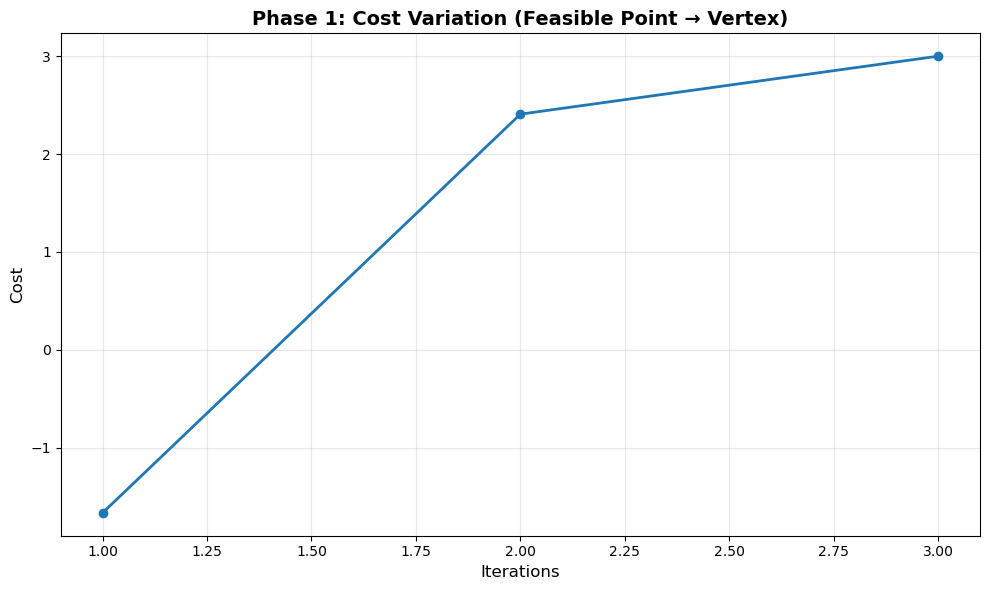

In [11]:
print_header("GENERATING VISUALIZATIONS")

# Cost plot for Phase 1
iterations = range(1, len(feas2vert_z_all_cost) + 1)
plt.figure(figsize=(10, 6))
plt.plot(iterations, feas2vert_z_all_cost, marker='o', linewidth=2, markersize=6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('Phase 1: Cost Variation (Feasible Point → Vertex)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

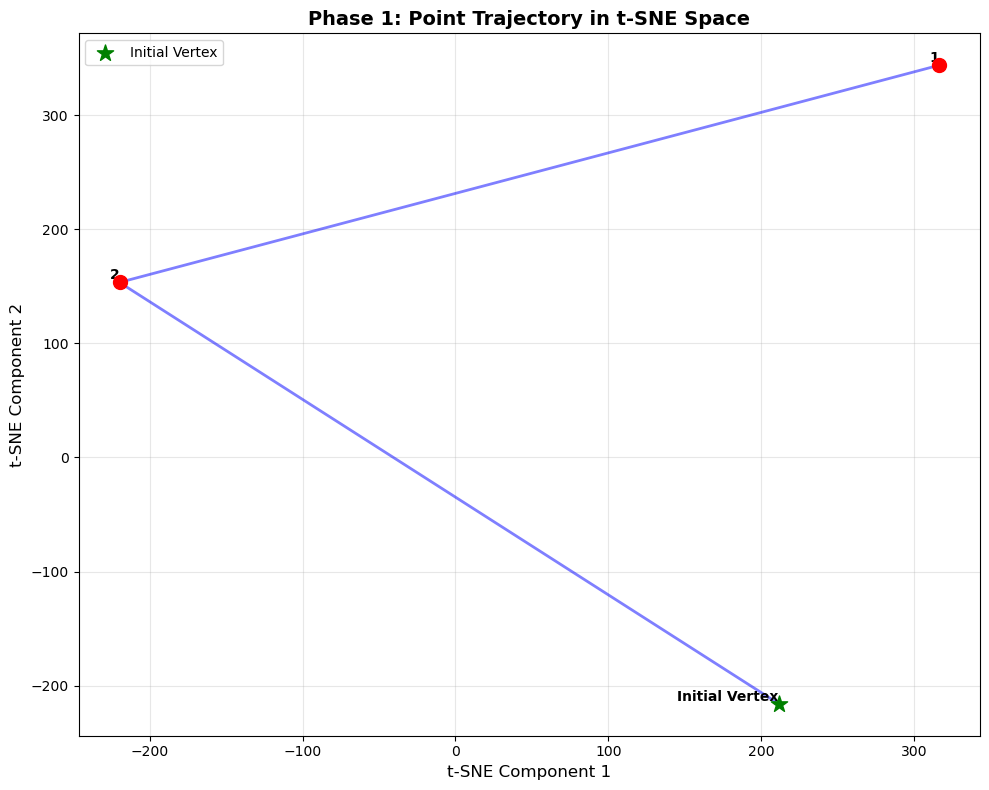

In [25]:
# t-SNE visualization for Phase 1
vectors = np.stack(feas2vert_z_all)
if len(vectors) > 1:
    tsne = TSNE(n_components=2, random_state=42, perplexity=len(vectors) - 1)
    vectors_2d = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    for i in range(len(vectors_2d) - 1):
        plt.plot([vectors_2d[i][0], vectors_2d[i + 1][0]], 
                [vectors_2d[i][1], vectors_2d[i + 1][1]], 
                'b-', alpha=0.5, linewidth=2)
        plt.scatter(vectors_2d[i][0], vectors_2d[i][1], color='red', s=100, zorder=5)
        plt.text(vectors_2d[i][0], vectors_2d[i][1], str(i + 1),
                ha='right', va='bottom', fontsize=10, fontweight='bold')

    plt.scatter(vectors_2d[-1][0], vectors_2d[-1][1], color='green', s=150, 
               marker='*', label='Initial Vertex', zorder=5)
    plt.text(vectors_2d[-1][0], vectors_2d[-1][1], "Initial Vertex",
            ha='right', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('Phase 1: Point Trajectory in t-SNE Space', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("  [INFO] Cannot generate t-SNE plot - only one vector available")

### Phase 2 Visualizations

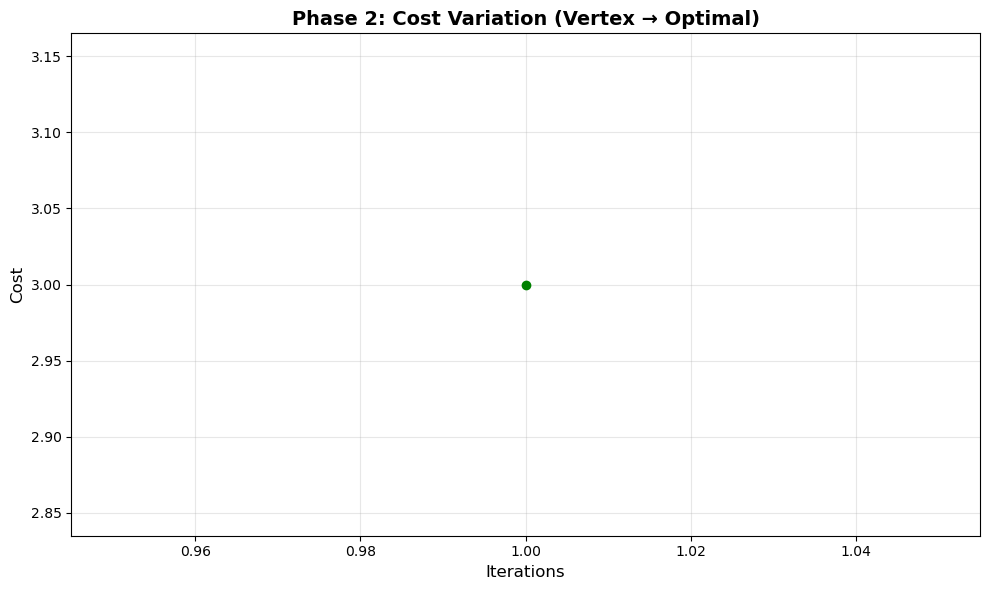

In [26]:
# Cost plot for Phase 2
if np.all(z_optimal == None):
    print("  [INFO] Problem is unbounded - showing available data")

iterations = range(1, len(vert2vert_z_all_cost) + 1)
plt.figure(figsize=(10, 6))
plt.plot(iterations, vert2vert_z_all_cost, marker='o', linewidth=2, markersize=6, color='green')
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('Phase 2: Cost Variation (Vertex → Optimal)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# t-SNE visualization for Phase 2
if np.all(z_optimal == None):
    final_point = "Final Vertex"
else:
    final_point = "Optimal Vertex"

vectors = np.stack(vert2vert_z_all)
if len(vectors) > 1:
    tsne = TSNE(n_components=2, random_state=42, perplexity=len(vectors) - 1)
    vectors_2d = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    for i in range(len(vectors_2d) - 1):
        plt.plot([vectors_2d[i][0], vectors_2d[i + 1][0]],
                [vectors_2d[i][1], vectors_2d[i + 1][1]],
                'g-', alpha=0.5, linewidth=2)
        plt.scatter(vectors_2d[i][0], vectors_2d[i][1], color='blue', s=100, zorder=5)
        plt.text(vectors_2d[i][0], vectors_2d[i][1], str(i + 1),
                ha='right', va='bottom', fontsize=10, fontweight='bold')

    plt.scatter(vectors_2d[-1][0], vectors_2d[-1][1], color='gold', s=150,
               marker='*', label=final_point, zorder=5)
    plt.text(vectors_2d[-1][0], vectors_2d[-1][1], final_point,
            ha='right', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.title('Phase 2: Vertex Trajectory in t-SNE Space', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("  [INFO] Cannot generate t-SNE plot - only one vector available")

  [INFO] Cannot generate t-SNE plot - only one vector available


In [15]:
print_header("EXECUTION COMPLETE")


  EXECUTION COMPLETE
